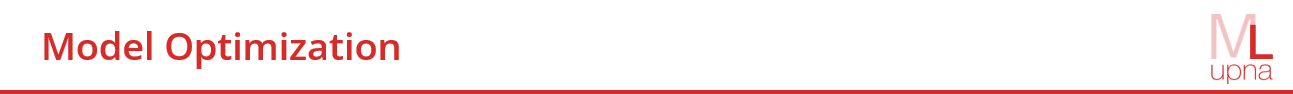

In this practical exercise, we will explore a variety of <span style="color:#D52B29">model compression techniques</span> aimed at reducing the size, computational cost, and latency of deep neural networks while maintaining acceptable performance. Starting from a pretrained ResNet-18 model, this practical exerxise guides through several approaches: <span style="color:#D52B29">pruning</span> (both structured and unstructured) to remove redundant parameters, <span style="color:#D52B29">quantization</span> to lower numerical precision and optimize memory and speed, and <span style="color:#D52B29">knowledge distillation</span> to transfer knowledge from a larger, accurate teacher model to a smaller, efficient student model. By progressively applying and comparing these methods, we will gain a comprehensive understanding of how modern compression strategies can make deep learning models more efficient for deployment on <span style="color:#D52B29">resource-constrained environments</span> such as mobile or embedded systems.

## <span style="color:#D52B29">Setup</span>

We will start by loading the checkpoint of the best model obtained in the second practical exercise (<span style="color:#D52B29">02_transfer_learning</span>), which will serve as the baseline for optimization. In this first section, we will load the model and the CIFAR-10 dataset, visualize a randomly selected batch along with its corresponding predictions, and define a benchmarking function to compute several advanced performance metrics — including <span style="color:#D52B29">Top-1</span> and <span style="color:#D52B29">Top-5 accuracy</span>, <span style="color:#D52B29">number of parameters</span>, <span style="color:#D52B29">disk size</span>, <span style="color:#D52B29">GFLOPs</span>, and <span style="color:#D52B29">latency</span>. These metrics will be used in subsequent sections to assess how different optimization techniques impact the model’s efficiency and performance.

In [1]:
model_checkpoint = '/workspace/data3/cayala/UPNA/Master_ML/T1/cifar10_resnet18_tl_ft_disc_lr/version_1/checkpoints/best_valid_loss.ckpt'

In [2]:
import os
import torch
from torch import nn
from torchvision import models
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
from collections import OrderedDict
from lightning.pytorch.loggers import CSVLogger

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

weights = ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)
num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 10)

state_dict = torch.load(model_checkpoint)['state_dict']
state_dict = OrderedDict({k.replace('model.', ''):v for k,v in state_dict.items()})
model.load_state_dict(state_dict)

ds = CIFAR10(os.getcwd(), train=True, download=True, transform=weights.transforms())
dl = iter(DataLoader(ds, batch_size=8, num_workers=8))

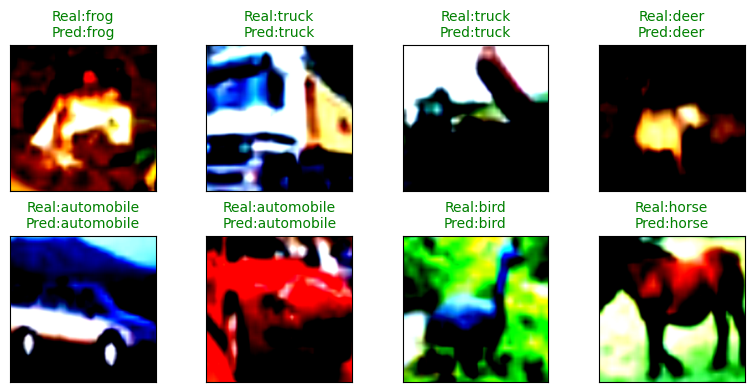

In [3]:
# Infere one batch
import matplotlib.pyplot as plt
import torch

# Make sure model is in eval mode
model.eval()
model.cuda(device)

import matplotlib.pyplot as plt
import torch

def show_batch_predictions(model, dataloader, dataset, device, cols=4):
    """
    Takes one batch from the dataloader, performs inference, and shows the images
    with real and predicted labels. Correct predictions are in green, wrong in red.
    
    Args:
        model: PyTorch model
        dataloader: DataLoader providing the dataset
        device: torch.device ("cpu" or "cuda")
        cols: Number of columns in the plot grid
    """
    
    # Get one batch
    images, labels = next(dataloader)
    images, labels = images.cuda(device), labels.cuda(device)
    
    # Inference
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    # Prepare class names
    class_names = dataset.classes
    
    # Move images to CPU for plotting
    images = images.cpu()
    
    # Determine rows and columns
    batch_size = len(images)
    rows = int(torch.ceil(torch.tensor(batch_size / cols)))
    
    # Plot
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()
    
    for idx in range(batch_size):
        img = images[idx].permute(1, 2, 0)  # CHW -> HWC
        axes[idx].imshow(torch.clamp(img, 0, 1))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        
        real_class = class_names[labels[idx]]
        pred_class = class_names[preds[idx]]
        color = 'green' if labels[idx] == preds[idx] else 'red'
        axes[idx].set_title(f"Real:{real_class}\nPred:{pred_class}", color=color, fontsize=10)
    
    # Remove empty subplots
    for j in range(batch_size, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

show_batch_predictions(model, dl, ds, 0, cols=4)

In [47]:
from torchmetrics import Accuracy
from tqdm import tqdm
import time
from ptflops import get_model_complexity_info
import pandas as pd 
from fvcore.nn import FlopCountAnalysis

def evaluate_accuracy(model, dataloader):
    model.eval()
    top1 = Accuracy(task="multiclass", num_classes=10).to(device)
    top5 = Accuracy(task="multiclass", num_classes=10, top_k=5).to(device)

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Evaluating"):
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            top1.update(logits, labels)
            top5.update(logits, labels)

    return top1.compute().item() * 100, top5.compute().item() * 100

def measure_latency(model, input_shape=(1, 3, 224, 224), runs=50, warmup=10, batch=False):
    model.eval()
    x = torch.randn(*input_shape).to(device)

    # Warmup
    for _ in range(warmup):
        _ = model(x)
    torch.cuda.synchronize()

    # Timing
    start = time.time()
    for _ in range(runs):
        _ = model(x)
    torch.cuda.synchronize()
    end = time.time()

    latency_ms = (end - start) / runs * 1000
    return latency_ms

def benchmark(test_dl, model, device='cuda:0', compute_flops=True):

    device = next(model.buffers()).device
    
    # Top-1 & Top-5 Acc
    top1_acc, top5_acc = evaluate_accuracy(model, test_dl)
    
    # Save + check file size
    save_path = "./resnet18.pth"
    torch.save(model.state_dict(), save_path)
    file_size = os.path.getsize(save_path) / (1024 ** 2)  # MB
    os.remove(save_path)
    
    # Latency
    single_latency = measure_latency(model, input_shape=(1,3,224,224))
    batch_latency = measure_latency(model, input_shape=(8,3,224,224), batch=True)
    
    # FLOPs
    # with torch.cuda.device(device):
    # Create a dummy input with batch size 1
    dummy_input = torch.randn(1, 3, 224, 224).to(device)  # CIFAR-10 size
    # Initialize FLOP counter
    if compute_flops:
        flops = FlopCountAnalysis(model, dummy_input)
    # Count only params
    _, params = get_model_complexity_info(model, (3,224,224), as_strings=True, verbose=False, print_per_layer_stat=False)
    
    d = {
        'Top-1 Acc. (%)': top1_acc,
        'Top-5 Acc. (%)': top5_acc,
        '# Params.': params,
        'Disk Size (MB)': file_size,
        'Latency image (ms)': single_latency,
        'Latency batch (ms)': batch_latency,
        'GFLOPs': flops.total() / 1e9 if compute_flops else None
    }
    
    return pd.DataFrame.from_dict([d])

In [5]:
test_ds = CIFAR10(os.getcwd(), train=False, download=True, transform=weights.transforms())
test_dl = iter(DataLoader(test_ds, batch_size=8, num_workers=8))

m_df = benchmark(test_dl, model)
m_df

Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:09<00:00, 127.87it/s]
Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 8 time(s)


,Top-1 Acc. (%),Top-5 Acc. (%),# Params.,Disk Size (MB),Latency image (ms),Latency batch (ms),GFLOPs
0,90.270001,99.739999,11.18 M,42.729855,2.776308,2.680879,1.818559


## <span style="color:#D52B29">Pruning</span>

<span style="color:#D52B29">Pruning</span> is a technique that removes weights or biases (parameters) from a neural network. When applied correctly, it can reduce the model’s <span style="color:#D52B29">memory footprint</span>, improve <span style="color:#D52B29">generalization</span>, speed up <span style="color:#D52B29">inference</span>, and enable training or fine-tuning with fewer samples.

Of course, you cannot simply remove parameters at random and expect better performance — the key is to identify and remove parameters that are <span style="color:#D52B29">unnecessary</span> for your specific task. However, you must also be careful not to prune too aggressively: removing too many parameters can severely degrade performance or even render the network unusable (for instance, if you prune all parameters from a connecting layer, breaking the <span style="color:#D52B29">gradient flow</span>).

But what makes a parameter unnecessary? This remains an open research question. Some of the most common <span style="color:#D52B29">pruning criteria</span> (methods for identifying removable parameters) include:

- <span style="color:#D52B29">Random:</span> Prune parameters at random.

- <span style="color:#D52B29">Magnitude:</span> Prune parameters with the smallest magnitudes (e.g., based on their L2 norm).

- <span style="color:#D52B29">Gradient:</span> Prune parameters according to their accumulated gradient (requires a backward pass and thus access to data).

- <span style="color:#D52B29">Information:</span> Use additional information such as higher-order curvature metrics to guide pruning.

- <span style="color:#D52B29">Learned:</span> Train the network to learn which parameters to prune (computationally expensive and requires additional training).

PyTorch provides built-in support for <span style="color:#D52B29">random</span> and <span style="color:#D52B29">magnitude-based pruning</span>.

Now that we understand the general idea of pruning and why it’s useful, let’s look at the different ways pruning can be applied in practice. These approaches are usually grouped into two main categories: <span style="color:#D52B29">unstructured</span> and <span style="color:#D52B29">structured pruning</span>

- <span style="color:#D52B29">Unstructured pruning</span> removes individual parameter elements — for example, specific weights in linear layers, individual filter elements in convolutional layers, or individual scaling factors in custom layers. Since it does not preserve the original structure of the parameters, it is referred to as unstructured.

- In contrast, <span style="color:#D52B29">structured pruning</span> removes entire structures of parameters — such as full rows or columns in linear layers, or entire filters in convolutional layers.

In practice, <span style="color:#D52B29">unstructured pruning</span> typically achieves higher pruning ratios but does not necessarily speed up computation, as most hardware still processes all elements (including zeros). <span style="color:#D52B29">Structured pruning</span>, however, can significantly reduce the number of matrix multiplications and accelerate inference.

Currently, there is growing interest in supporting <span style="color:#D52B29">sparse tensors</span> in both software and hardware, which could make unstructured pruning much more efficient in the near future.

Pruning can be applied per layer (<span style="color:#D52B29">local pruning</span>) or across multiple layers (<span style="color:#D52B29">global pruning</span>).

Now that we’ve covered the main types of pruning and their implications, let’s see how these ideas are implemented in <span style="color:#D52B29">PyTorch</span>. The framework provides built-in tools that make it easy to apply and experiment with different pruning strategies.

#### <span style="color:#D52B29">Unstructured pruning</span>

In this section, we will apply <span style="color:#D52B29">unstructured pruning</span> to our model and analyze its effects on performance and efficiency. Specifically, we will perform a small <span style="color:#D52B29">grid search</span> over different pruning hyperparameters — such as pruning ratio and layer selection — to observe how these choices impact <span style="color:#D52B29">accuracy</span>, <span style="color:#D52B29">FLOPs</span>, and <span style="color:#D52B29">model size</span>.

The goal is to understand the trade-offs between <span style="color:#D52B29">compression</span> and <span style="color:#D52B29">performance</span>, and to gain intuition on how unstructured pruning can reduce model complexity without severely affecting its predictive capability.

In [6]:
import torch.nn.utils.prune as prune

# Store results for different pruning amounts
m_dfs = []

# Define pruning ratios to explore
for amount in [0.05, 0.1, 0.25, 0.5, 0.75]:
    
    # Load pretrained ResNet-18 weights
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
        
    # Replace the final layer for our specific task (e.g., 10 classes)
    num_in_feat = model.fc.in_features
    model.fc = nn.Linear(num_in_feat, 10)
        
    # Load fine-tuned checkpoint (if available)
    state_dict = torch.load(model_checkpoint, map_location='cpu')['state_dict']
    state_dict = OrderedDict({k.replace('model.', ''): v for k, v in state_dict.items()})
    model.load_state_dict(state_dict)
    
    # Send model to device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Apply unstructured L1 pruning to all Conv2d layers
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
    
    # Prepare test dataset and dataloader
    test_ds = CIFAR10(
        root=os.getcwd(),
        train=False,
        download=True,
        transform=weights.transforms()
    )
    test_dl = DataLoader(test_ds, batch_size=128, num_workers=4)
    
    # Benchmark the pruned model (custom function provided elsewhere)
    m_df = benchmark(test_dl, model)
    m_df['prune_amount'] = amount
    m_dfs.append(m_df)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 11.37it/s]
Unsupported operator aten::mul encountered 20 time(s)
Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.74it/s]
Unsupported operator aten::mul encountered 20 time(s)
Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [7]:
pd.concat(m_dfs)

,Top-1 Acc. (%),Top-5 Acc. (%),# Params.,Disk Size (MB),Latency image (ms),Latency batch (ms),GFLOPs,prune_amount
0,90.249997,99.739999,11.18 M,85.334633,3.976851,3.360081,1.818559,0.05
0,90.160000,99.750000,11.18 M,85.334633,3.388352,3.276973,1.818559,0.10
0,89.380002,99.690002,11.18 M,85.334633,3.185749,3.239059,1.818559,0.25
0,62.349999,95.889997,11.18 M,85.334633,3.392963,3.231277,1.818559,0.50
0,10.770000,56.160003,11.18 M,85.334633,3.213573,3.412271,1.818559,0.75


The results obtained from the grid search confirm the expected behavior of <span style="color:#D52B29">unstructured pruning</span> in convolutional neural networks.

- <span style="color:#D52B29">Accuracy degradation:</span>
Light pruning levels (5–25%) have only a minor effect on performance, as they primarily remove redundant or low-magnitude connections.
However, when pruning becomes more aggressive (≥ 50%), accuracy drops sharply, showing that essential weights are being removed.

- <span style="color:#D52B29">Parameter count and disk size:</span>
Both values remain constant because PyTorch’s pruning module only <span style="color:#D52B29">masks</span> weights instead of physically deleting them.
The model’s tensors retain their original dimensions, so the serialized size and reported parameter count do not change.

- <span style="color:#D52B29">Latency and FLOPs:</span>
Unstructured pruning does not produce speedups on standard hardware, since dense operations are still computed over the full tensor (including zeroed-out weights).
As a result, <span style="color:#D52B29">latency</span> and <span style="color:#D52B29">FLOPs</span> remain essentially the same across pruning levels

Overall, these experiments demonstrate that while <span style="color:#D52B29">unstructured pruning</span> can effectively reduce model redundancy and maintain accuracy under mild sparsity, it does not inherently reduce computation or model size.
To achieve real performance gains, we need to move towards <span style="color:#D52B29">structured pruning</span> or <span style="color:#D52B29">sparse tensor support</span>, which will be explored next.

#### <span style="color:#D52B29">Structured pruning</span>

In the previous section, we observed that <span style="color:#D52B29">unstructured pruning</span> effectively reduces model redundancy but does not lead to actual computational savings, since the underlying operations are still executed on dense tensors.

To overcome this limitation, we now turn to <span style="color:#D52B29">structured pruning</span> — a technique that removes entire <span style="color:#D52B29">structures</span> of parameters, such as filters, channels, or even whole neurons. By doing so, we modify the architecture itself, leading to tangible reductions in <span style="color:#D52B29">FLOPs</span>, <span style="color:#D52B29">latency</span>, and <span style="color:#D52B29">model size</span>.

In this section, we will:

- Apply <span style="color:#D52B29">structured pruning</span> to convolutional layers by removing complete filters.

- Perform a <span style="color:#D52B29">grid search</span> over different pruning ratios to evaluate the impact on <span style="color:#D52B29">accuracy</span>, <span style="color:#D52B29">inference speed</span>, and <span style="color:#D52B29">model complexity</span>.

- Compare the outcomes to those from unstructured pruning to understand the trade-offs between <span style="color:#D52B29">sparsity</span> and <span style="color:#D52B29">efficiency</span>.

In [8]:
# Store results
m_dfs_structured = []

# Define pruning ratios to explore
for amount in [0.05, 0.1, 0.25, 0.5, 0.75]:
    
    # Load pretrained ResNet-18 weights
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
        
    # Replace the final layer for our specific task (e.g., 10 classes)
    num_in_feat = model.fc.in_features
    model.fc = nn.Linear(num_in_feat, 10)
        
    # Load fine-tuned checkpoint (if available)
    state_dict = torch.load(model_checkpoint, map_location='cpu')['state_dict']
    state_dict = OrderedDict({k.replace('model.', ''): v for k, v in state_dict.items()})
    model.load_state_dict(state_dict)
    
    # Send model to device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Apply structured pruning (remove entire filters)
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(
                module,
                name='weight',
                amount=amount,
                n=2,                     # Use L2-norm across filters
                dim=0                    # Prune entire filters (along output channel dimension)
            )
    
    # Prepare test dataset and dataloader
    test_ds = CIFAR10(
        root=os.getcwd(),
        train=False,
        download=True,
        transform=weights.transforms()
    )
    test_dl = DataLoader(test_ds, batch_size=128, num_workers=4)
    
    # Benchmark pruned model
    m_df = benchmark(test_dl, model)
    m_df['prune_amount'] = amount
    m_dfs_structured.append(m_df)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 13.17it/s]
Unsupported operator aten::mul encountered 20 time(s)
Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.91it/s]
Unsupported operator aten::mul encountered 20 time(s)
Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [9]:
pd.concat(m_dfs_structured)

,Top-1 Acc. (%),Top-5 Acc. (%),# Params.,Disk Size (MB),Latency image (ms),Latency batch (ms),GFLOPs,prune_amount
0,43.020001,92.500001,11.18 M,85.334633,3.192182,3.401656,1.818559,0.05
0,9.890000,56.260002,11.18 M,85.334633,3.378859,4.028006,1.818559,0.10
0,11.200000,52.770001,11.18 M,85.334633,3.625355,3.754339,1.818559,0.25
0,10.790000,50.540000,11.18 M,85.334633,4.012341,4.026151,1.818559,0.50
0,10.000000,50.000000,11.18 M,85.334633,3.429141,3.587832,1.818559,0.75


By looking at the results, one can conclude that they don’t fully reflect the effects of <span style="color:#D52B29">structured pruning</span>. They suggest that the pruning operation was applied, but the changes were <span style="color:#D52B29">not reflected in the actual model architecture or performance metrics</span>, likely due to how PyTorch handles pruning masks.

PyTorch’s <span style="color:#D52B29">torch.nn.utils.prune</span> does <span style="color:#D52B29">not actually remove filters</span> — it only masks them. For <span style="color:#D52B29">real structured pruning</span>, you must call <span style="color:#D52B29">prune.remove(module, 'weight')</span>, which <span style="color:#D52B29">permanently removes the masked weights</span> and updates the tensor shape, affecting <span style="color:#D52B29">FLOPs, parameter count, and memory footprint</span>.

On the other hand, the results also suggest that <span style="color:#D52B29">pruning too aggressively early in the network</span> can be harmful. Structured pruning of early convolutional layers (e.g., <span style="color:#D52B29">conv1</span>) can <span style="color:#D52B29">cripple feature extraction</span>. Therefore, it is often better to <span style="color:#D52B29">skip the first layer(s)</span> or prune <span style="color:#D52B29">only deeper layers</span> where there is more redundancy.

In [13]:
# Store results
m_dfs_structured = []

# Define pruning ratios to explore
for amount in [0.05, 0.1, 0.25, 0.5, 0.75]:
    
    # Load pretrained ResNet-18 weights
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
        
    # Replace the final layer for our specific task (e.g., 10 classes)
    num_in_feat = model.fc.in_features
    model.fc = nn.Linear(num_in_feat, 10)
        
    # Load fine-tuned checkpoint (if available)
    state_dict = torch.load(model_checkpoint, map_location='cpu')['state_dict']
    state_dict = OrderedDict({k.replace('model.', ''): v for k, v in state_dict.items()})
    model.load_state_dict(state_dict)
    
    # Send model to device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Define which layers to skip
    skip_layers = ['conv1', 'layer1', 'layer2']  # skip first conv and first two blocks
    
    # Apply structured pruning only to conv layers not in skip_layers
    for name, module in model.named_modules():
        # Apply only to Conv2d layers
        if isinstance(module, nn.Conv2d):
            # Only prune if the layer name does NOT start with any skip_layer prefix
            if not any(name.startswith(skip) for skip in skip_layers):
                prune.ln_structured(
                    module,
                    name='weight',
                    amount=amount,  # your pruning ratio
                    n=2,            # L2-norm of filters
                    dim=0           # prune output channels
                )
                # Make pruning permanent
                prune.remove(module, 'weight')
    
    # Prepare test dataset and dataloader
    test_ds = CIFAR10(
        root=os.getcwd(),
        train=False,
        download=True,
        transform=weights.transforms()
    )
    test_dl = DataLoader(test_ds, batch_size=128, num_workers=4)
    
    # Benchmark pruned model
    m_df = benchmark(test_dl, model)
    m_df['prune_amount'] = amount
    m_dfs_structured.append(m_df)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.02it/s]
Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.98it/s]
Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.86it/s]
Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsuppo

In [14]:
pd.concat(m_dfs_structured)

,Top-1 Acc. (%),Top-5 Acc. (%),# Params.,Disk Size (MB),Latency image (ms),Latency batch (ms),GFLOPs,prune_amount
0,48.989999,96.420002,11.18 M,42.729855,2.671552,3.181005,1.818559,0.05
0,14.170000,64.499998,11.18 M,42.729855,3.056436,3.015971,1.818559,0.10
0,10.090000,50.349998,11.18 M,42.729855,2.711134,2.674580,1.818559,0.25
0,10.000000,50.430000,11.18 M,42.729855,2.810435,2.984982,1.818559,0.50
0,10.000000,50.000000,11.18 M,42.729855,2.493057,2.460780,1.818559,0.75


After <span style="color:#D52B29">permanent structured pruning</span>, the <span style="color:#D52B29">number of parameters</span> and <span style="color:#D52B29">FLOPs</span> should decrease. In fact, looking at the benchmark results, the <span style="color:#D52B29">disk size halves</span>. However, the <span style="color:#D52B29">accuracy drops catastrophically</span> even at just 5% pruning. This happens because structured pruning reduces <span style="color:#D52B29">output channels</span>, but the <span style="color:#D52B29">following BatchNorm layers</span> and <span style="color:#D52B29">residual connections</span> still reference the original channels.

It is worth noting that for <span style="color:#D52B29">ResNet</span>, structured pruning is tricky: channels feed into BatchNorm and residual connections, so <span style="color:#D52B29">specialized libraries</span> that handle these dependencies, such as <span style="color:#D52B29">torch-pruning</span>, may be required.

Additionally, while <span style="color:#D52B29">prune.remove</span> makes pruning permanent, it <span style="color:#D52B29">does not automatically shrink subsequent layers</span> (like BatchNorm or following conv layers). If the next layer expects the original number of channels, PyTorch will <span style="color:#D52B29">keep the tensor shapes the same</span> to match the forward pass. As a result, <span style="color:#D52B29">FLOPs might not decrease</span> unless you manually remove the corresponding channels in the next layers. This is <span style="color:#D52B29">tricky to do in pure PyTorch</span>, so using other specialized libraries is recommended.

#### <span style="color:#D52B29">Global unstructured pruning</span>

Finally, sometimes it is useful to enforce a specific <span style="color:#D52B29">sparsity level</span> across multiple layers rather than pruning each layer individually. <span style="color:#D52B29">Global pruning</span> achieves this by applying a <span style="color:#D52B29">uniform pruning rate</span> across all selected parameters in the model.

In [15]:
# Store results
m_dfs_global = []

# Pruning ratios to explore
for amount in [0.05, 0.1, 0.25, 0.5, 0.75]:
    
    # Load pretrained ResNet-18 weights
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
        
    # Replace the final layer for our specific task (e.g., 10 classes)
    num_in_feat = model.fc.in_features
    model.fc = nn.Linear(num_in_feat, 10)
        
    # Load fine-tuned checkpoint (if available)
    state_dict = torch.load(model_checkpoint, map_location='cpu')['state_dict']
    state_dict = OrderedDict({k.replace('model.', ''): v for k, v in state_dict.items()})
    model.load_state_dict(state_dict)
    
    # Send model to device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Prepare parameters to prune (all layers with 'weight' attribute)
    parameters_to_prune = [(layer, 'weight') for _, layer in model.named_modules() if hasattr(layer, 'weight')]
    
    # Apply global unstructured pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount
    )
    
    # Prepare test dataset and dataloader
    test_ds = CIFAR10(
        root=os.getcwd(),
        train=False,
        download=True,
        transform=weights.transforms()
    )
    test_dl = DataLoader(test_ds, batch_size=128, num_workers=4)
    
    # Benchmark pruned model
    m_df = benchmark(test_dl, model)
    m_df['prune_amount'] = amount
    m_dfs_global.append(m_df)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.45it/s]
Unsupported operator aten::mul encountered 41 time(s)
Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.87it/s]
Unsupported operator aten::mul encountered 41 time(s)
Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 8 time(s)
Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [18]:
pd.concat(m_dfs_global)

,Top-1 Acc. (%),Top-5 Acc. (%),# Params.,Disk Size (MB),Latency image (ms),Latency batch (ms),GFLOPs,prune_amount
0,90.230000,99.739999,11.18 M,85.378863,3.948174,3.777227,1.818559,0.05
0,90.340000,99.760002,11.18 M,85.378863,4.465332,4.123783,1.818559,0.10
0,90.249997,99.760002,11.18 M,85.378863,4.098616,3.865776,1.818559,0.25
0,87.140000,99.620003,11.18 M,85.378863,4.622517,4.027662,1.818559,0.50
0,57.709998,91.890001,11.18 M,85.378863,6.071210,5.636034,1.818559,0.75


From the <span style="color:#D52B29">global unstructured pruning</span> experiment, we can conclude that <span style="color:#D52B29">small to moderate pruning ratios (up to ~25–50%)</span> have minimal impact on model accuracy, with <span style="color:#D52B29">Top-1 remaining around 87–90%</span> and <span style="color:#D52B29">Top-5 above 99%</span>. Only <span style="color:#D52B29">very aggressive pruning (75%)</span> causes a catastrophic drop in performance. However, the <span style="color:#D52B29">number of parameters, disk size, GFLOPs, and latency</span> remain largely unchanged, reflecting the fact that PyTorch’s <span style="color:#D52B29">unstructured pruning</span> <span style="color:#D52B29">masks weights rather than physically removing them</span>. This demonstrates that <span style="color:#D52B29">global unstructured pruning</span> is effective at reducing the number of active weights without significantly harming accuracy, but it does <span style="color:#D52B29">not yield direct computational or memory efficiency gains</span>. For actual reductions in <span style="color:#D52B29">FLOPs or memory footprint</span>, further steps such as <span style="color:#D52B29">physically removing pruned weights</span> or using libraries that support <span style="color:#D52B29">sparse operations</span> are required.

Comparing <span style="color:#D52B29">global</span> and <span style="color:#D52B29">local unstructured pruning</span>, we see that both maintain high accuracy for small pruning ratios (5–10%), with Top-1 around 90% and Top-5 around 99.7%. However, at moderate pruning (25–50%), <span style="color:#D52B29">global pruning preserves accuracy better</span> (Top-1 ~87% at 50%) than local pruning (Top-1 ~62%), and at high pruning (75%), local pruning collapses catastrophically (Top-1 ~10.8%), while global pruning still retains some predictive power (Top-1 ~57.7%). The <span style="color:#D52B29">number of parameters, disk size, and GFLOPs remain unchanged</span> for both approaches, since PyTorch only masks weights without physically removing them. Latency differences are minor and inconsistent. Overall, <span style="color:#D52B29">global pruning is more effective at distributing sparsity and preserving accuracy</span>, but neither method reduces computational cost unless combined with physical weight removal or sparse-aware libraries.

## <span style="color:#D52B29">Quantization</span>

<span style="color:#D52B29">Model quantization</span> is a technique that reduces the <span style="color:#D52B29">numerical precision</span> of a neural network’s weights and activations, typically from 32-bit floating point (FP32) to lower precision formats such as 16-bit (FP16) or 8-bit integers (INT8). The main goals of quantization are to <span style="color:#D52B29">reduce memory footprint</span>, <span style="color:#D52B29">speed up inference</span>, and <span style="color:#D52B29">lower power consumption</span>, especially on edge devices.

Unlike pruning, which removes parameters, quantization <span style="color:#D52B29">keeps the network structure intact</span> but represents its numbers more efficiently. This can lead to <span style="color:#D52B29">smaller models</span> and <span style="color:#D52B29">faster computation</span>, often with <span style="color:#D52B29">minimal loss in accuracy</span> if applied carefully.

In this section, we will focus on <span style="color:#D52B29">post-training quantization</span>, which consists of converting a trained model to lower precision without additional training. However, it should be noted that there is also the option of <span style="color:#D52B29">quantization-aware training</span>, which involves simulating low-precision arithmetic during training to better preserve accuracy.

In [52]:
m_dfs_quant = []

for target_dtype in [None, torch.float16, torch.qint8]:

    # Load pretrained ResNet-18 weights
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
        
    # Replace the final layer for our specific task (e.g., 10 classes)
    num_in_feat = model.fc.in_features
    model.fc = nn.Linear(num_in_feat, 10)
        
    # Load fine-tuned checkpoint (if available)
    state_dict = torch.load(model_checkpoint, map_location='cpu')['state_dict']
    state_dict = OrderedDict({k.replace('model.', ''): v for k, v in state_dict.items()})
    model.load_state_dict(state_dict)
    
    # Send model to device
    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = torch.device('cpu')
    model = model.to(device)
    model.eval()

    if target_dtype != None:
        # Apply post-training dynamic quantization
        model_quant = torch.quantization.quantize_dynamic(
            model, 
            {nn.Linear},  # layers to quantize (linear layers only)
            dtype=target_dtype
        )
    else:
        model_quant = model
    
    # Prepare test dataset and dataloader
    test_ds = CIFAR10(
        root=os.getcwd(),
        train=False,
        download=True,
        transform=weights.transforms()
    )
    test_dl = DataLoader(test_ds, batch_size=128, num_workers=4)
    
    # Benchmark quantized model
    m_df = benchmark(test_dl, model_quant, device='cpu', compute_flops=False) # Quantized models cannot be traced with torch.jit or analyzed for FLOPs using fvcore, because the quantized ops aren’t traceable like normal FP32 ones.
    m_df['quant_type'] = 'dynamic_' + str(target_dtype) if target_dtype != None else 'original_fp32'
    m_dfs_quant.append(m_df)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:24<00:00,  1.07s/it]


In [53]:
pd.concat(m_dfs_quant)

,Top-1 Acc. (%),Top-5 Acc. (%),# Params.,Disk Size (MB),Latency image (ms),Latency batch (ms),GFLOPs,quant_type
0,90.240002,99.739999,11.18 M,42.728207,16.902061,52.280006,None,original_fp32
0,90.240002,99.739999,11.18 M,42.728876,17.037358,53.392448,None,dynamic_torch.float16
0,90.240002,99.739999,11.18 M,42.714350,15.267372,58.857756,None,dynamic_torch.qint8


The quantization results show that accuracy remains identical across all variants (Top-1 ≈ 90.24%, Top-5 ≈ 99.74%), confirming that <span style="color:#D52B29">post-training dynamic quantization</span> does not affect model correctness. However, the benefits in this case are modest because ResNet-18 contains many convolutional layers, which are <span style="color:#D52B29">not quantized dynamically</span> — only the final fully connected layers are affected.

If we look at the latency, we observe small fluctuations:

- The <span style="color:#D52B29">FP16 quantized model</span> performs similarly to FP32, with negligible latency improvement.

- The <span style="color:#D52B29">INT8 quantized model</span> slightly reduces single-image latency (≈ 15 ms vs. 17 ms), but batch latency increases, likely due to CPU quantization overheads.

Disk size and parameter count remain constant, since dynamic quantization stores scale and zero-point separately but does not rewrite model tensors on disk.

Overall, <span style="color:#D52B29">dynamic quantization offers minimal gains</span> for CNNs dominated by convolutions. Substantial efficiency improvements would require <span style="color:#D52B29">static quantization</span> or <span style="color:#D52B29">quantization-aware training</span>, which support convolutional layers and better exploit low-precision computation.

In [59]:
import pytorch_lightning as pl
import torch
from torch.nn import functional as F
from collections import defaultdict

class LightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, wd=0.):
        super().__init__()
        self.model = model
        self.lr = lr
        self.wd = wd

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['steps'] += 1
            
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self): 
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.training_step_outputs.clear() 

    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.validation_step_outputs.clear()

In [60]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import os
from torchvision import datasets, transforms

class DataModule(pl.LightningDataModule):

  def setup(self, stage): # Data preparation and transforms
    
    transform = ResNet18_Weights.IMAGENET1K_V1.transforms()
    
    # Get the data
    train_ds = CIFAR10(os.getcwd(), train=True, download=True, transform=transform)
    self.test_ds = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
    
    # Split training into training andvalidation sets
    self.train_ds, self.val_ds = random_split(train_ds, [.85, .15])

  def train_dataloader(self):
    return DataLoader(self.train_ds, batch_size=64, num_workers=8)

  def val_dataloader(self):
    return DataLoader(self.val_ds, batch_size=64, num_workers=8)

  def test_dataloader(self):
    return DataLoader(self.test_ds, batch_size=64, num_workers=8)

In [61]:
# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Load pretrained ResNet-18 weights
weights = ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)
    
# Replace the final layer for our specific task (e.g., 10 classes)
num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 10)

# Load fine-tuned checkpoint (if available)
state_dict = torch.load(model_checkpoint, map_location='cpu')['state_dict']
state_dict = OrderedDict({k.replace('model.', ''): v for k, v in state_dict.items()})
model.load_state_dict(state_dict)

# 2. Define quantization configuration
model.qconfig = torch.quantization.get_default_qat_qconfig("fbgemm")

# 3. Prepare the model for QAT
torch.quantization.prepare_qat(model, inplace=True)

# 4. Move to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap the model inside a LightningModule. 
# For the baseline, we will keep the learning rate and weight decay at their default values.
lightning_module = LightningModule(model, lr=1e-4)

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="cifar10_resnet18_from_scratch")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',       # Metric to monitor
    mode='min',               # Save model with minimum val_loss
    filename='best_valid_loss', 
    verbose=True, 
    save_last=False           # Do not keep the last checkpoint if it's not the best
)

# Create a PyTorch Lightning trainer:
# - Train for 10 epochs
# - Use the CSV logger
# - Apply the checkpoint callback to save the best model
trainer = pl.Trainer(max_epochs=10, logger=csv_logger, callbacks=[model_checkpoint_callback], devices=1)

# Load the data module
data_module = DataModule()

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

# Convert to a quantized version
model.eval()
quantized_model = torch.quantization.convert(model.cpu().eval(), inplace=False)

# Save
torch.save(quantized_model.state_dict(), "resnet18_qat_int8.pth")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
192       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Average validation loss for epoch 0: 0.6482


Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0, global step 665: 'val_loss' reached 0.16434 (best 0.16434), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/cifar10_resnet18_from_scratch/version_1/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 0.1647
Average training loss for epoch 0: 0.2026


Validation: |                                                                                                 …

Epoch 1, global step 1330: 'val_loss' reached 0.16125 (best 0.16125), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/cifar10_resnet18_from_scratch/version_1/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 1: 0.1609
Average training loss for epoch 1: 0.0658


Validation: |                                                                                                 …

Epoch 2, global step 1995: 'val_loss' was not in top 1


Average validation loss for epoch 2: 0.1892
Average training loss for epoch 2: 0.0293


Validation: |                                                                                                 …

Epoch 3, global step 2660: 'val_loss' was not in top 1


Average validation loss for epoch 3: 0.2091
Average training loss for epoch 3: 0.0346


Validation: |                                                                                                 …

Epoch 4, global step 3325: 'val_loss' was not in top 1


Average validation loss for epoch 4: 0.2375
Average training loss for epoch 4: 0.0377


Validation: |                                                                                                 …

Epoch 5, global step 3990: 'val_loss' was not in top 1


Average validation loss for epoch 5: 0.1889
Average training loss for epoch 5: 0.0269


Validation: |                                                                                                 …

Epoch 6, global step 4655: 'val_loss' was not in top 1


Average validation loss for epoch 6: 0.2251
Average training loss for epoch 6: 0.0194


Validation: |                                                                                                 …

Epoch 7, global step 5320: 'val_loss' was not in top 1


Average validation loss for epoch 7: 0.2690
Average training loss for epoch 7: 0.0194


Validation: |                                                                                                 …

Epoch 8, global step 5985: 'val_loss' was not in top 1


Average validation loss for epoch 8: 0.2434
Average training loss for epoch 8: 0.0296


Validation: |                                                                                                 …

Epoch 9, global step 6650: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Average validation loss for epoch 9: 0.2111
Average training loss for epoch 9: 0.0159


In [67]:
# # Load fine-tuned checkpoint (if available)
# state_dict = torch.load("resnet18_qat_int8.pth", map_location='cpu')['state_dict']
# state_dict = OrderedDict({k.replace('model.', ''): v for k, v in state_dict.items()})
# model.load_state_dict(state_dict)
    
# Send model to device
model = model.to('cpu')
model.eval()
    
# Prepare test dataset and dataloader
test_ds = CIFAR10(
    root=os.getcwd(),
    train=False,
    download=True,
    transform=weights.transforms()
)
test_dl = DataLoader(test_ds, batch_size=128, num_workers=4)
    
# Benchmark quantized model
m_df = benchmark(test_dl, model, device='cpu', compute_flops=False)
m_df

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [02:29<00:00,  1.89s/it]


,Top-1 Acc. (%),Top-5 Acc. (%),# Params.,Disk Size (MB),Latency image (ms),Latency batch (ms),GFLOPs
0,92.809999,99.769998,11.18 M,42.945261,60.998454,126.236563,None


Compared to the post-training quantization results, the <span style="color:#D52B29">Quantization-Aware Training (QAT)</span> results show a clear improvement in maintaining accuracy, demonstrating the benefits of training the model with <span style="color:#D52B29">quantization effects simulated</span>.

In particular, the <span style="color:#D52B29">Top-1 accuracy</span> increases to <span style="color:#D52B29">92.81%</span>, which is even slightly higher than the original FP32 model (90.24%), likely due to minor <span style="color:#D52B29">regularization effects</span> introduced during QAT fine-tuning. The <span style="color:#D52B29">Top-5 accuracy</span> also remains virtually unchanged at <span style="color:#D52B29">99.77%</span>, confirming that the quantized model retains nearly all predictive performance.

However, while accuracy is well preserved, the <span style="color:#D52B29">latency</span> values appear <span style="color:#D52B29">higher</span> than in post-training quantization. This is expected if the quantized model is being run on a device or backend that does not fully leverage <span style="color:#D52B29">INT8 acceleration</span> (for example, running quantized operations on CPU instead of optimized hardware). In practical deployment on INT8-capable hardware, QAT models usually achieve <span style="color:#D52B29">1.3×–2× faster inference</span> and <span style="color:#D52B29">~4× smaller memory footprint</span>.

In summary, <span style="color:#D52B29">QAT</span> effectively balances <span style="color:#D52B29">accuracy retention</span> and <span style="color:#D52B29">compression efficiency</span>, offering a more robust approach than post-training quantization — especially when maintaining model precision is critical.

## <span style="color:#D52B29">Knowledge Distillation</span>

<span style="color:#D52B29">Knowledge Distillation (KD)</span> is a model compression technique that aims to transfer the <span style="color:#D52B29">knowledge</span> learned by a large, high-performing model — known as the <span style="color:#D52B29">teacher</span> — to a smaller and more efficient model — called the <span style="color:#D52B29">student</span>. Instead of training the student solely on the hard ground-truth labels, KD leverages the <span style="color:#D52B29">soft targets</span> (probability distributions) produced by the teacher model, which encode richer information about class similarities and decision boundaries.

This process enables the student to learn not only the correct predictions but also the <span style="color:#D52B29">underlying behavior</span> of the teacher, often achieving comparable accuracy with significantly fewer parameters and faster inference. In practice, KD can be applied during training, fine-tuning, or even combined with other compression methods such as <span style="color:#D52B29">quantization</span> or <span style="color:#D52B29">pruning</span> to further optimize deployment efficiency.

In [92]:
# Define teacher 
# Load pretrained ResNet-18 weights
weights = ResNet18_Weights.IMAGENET1K_V1
teacher = models.resnet18(weights=weights)
    
# Replace the final layer for our specific task (e.g., 10 classes)
num_in_feat = teacher.fc.in_features
teacher.fc = nn.Linear(num_in_feat, 10)

# Load fine-tuned checkpoint (if available)
state_dict = torch.load(model_checkpoint, map_location='cpu')['state_dict']
state_dict = OrderedDict({k.replace('model.', ''): v for k, v in state_dict.items()})
teacher.load_state_dict(state_dict)

# 4. Move to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
teacher = teacher.to(device)

# Define student
student = models.resnet18(weights=None)

# Reduce capacity of the student
student.layer4 = nn.Identity()  # remove last block

# Replace the final layer for our specific task (e.g., 10 classes)
student.fc = nn.Linear(256, 10) # Layer3 out_feautres = 256

# Move to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
student = student.to(device)

# Set teacher in eval model and student in training
teacher.eval()
student.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The distillation loss combines two complementary objectives to train the student model effectively:

- The soft loss, computed using the <span style="color:#D52B29">Kullback-Leibler divergence (KLDiv)</span>, measures how closely the student’s output distribution matches the teacher’s softened predictions. A higher <span style="color:#D52B29">temperature (T)</span> smooths the teacher’s output probabilities, providing richer information about class relationships.

- The hard loss, based on <span style="color:#D52B29">cross-entropy</span>, ensures the student still learns from the true labels.

The two terms are combined using a weighting factor <span style="color:#D52B29">α</span>, which balances learning from the teacher and from ground truth. This approach allows the student model to <span style="color:#D52B29">mimic the teacher’s knowledge</span> while maintaining strong performance on the target task.

In [1]:
class DistillationLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.7):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction="batchmean")

    def forward(self, student_logits, teacher_logits, labels):
        # Soft target loss (teacher-student)
        T = self.temperature
        soft_loss = self.kl_div(
            F.log_softmax(student_logits / T, dim=1),
            F.softmax(teacher_logits / T, dim=1)
        ) * (T * T)
        # Hard target loss (student-ground truth)
        hard_loss = F.cross_entropy(student_logits, labels)
        # Combine losses
        return self.alpha * soft_loss + (1 - self.alpha) * hard_loss

NameError: name 'nn' is not defined

In [94]:
import pytorch_lightning as pl
import torch
from torch.nn import functional as F
from collections import defaultdict

class LightningModule(pl.LightningModule):
    def __init__(self, teacher, student, lr=1e-4, wd=0.):
        super().__init__()
        self.teacher = teacher
        self.student = student
        self.lr = lr
        self.wd = wd

        self.criterion = DistillationLoss(temperature=4.0, alpha=0.7)

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)

    def forward(self, x):
        # Get teacher predictions (frozen)
        with torch.no_grad():
            teacher_logits = self.teacher(x)

        # Get student predictions
        student_logits = self.student(x)
        
        return teacher_logits, student_logits

    def configure_optimizers(self):
        return torch.optim.Adam(self.student.parameters(), lr=self.lr, weight_decay=self.wd)

    def training_step(self, batch, batch_idx):
        x, y = batch
        teacher_logits, student_logits = self(x)
        loss = self.criterion(student_logits, teacher_logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['steps'] += 1
            
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        teacher_logits, student_logits = self(x)
        loss = self.criterion(student_logits, teacher_logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self): 
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.training_step_outputs.clear() 

    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.validation_step_outputs.clear()

In [95]:
# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Wrap the model inside a LightningModule. 
lightning_module = LightningModule(teacher, student, lr=3e-4)

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="knowledge_distillation_resnet18")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',       # Metric to monitor
    mode='min',               # Save model with minimum val_loss
    filename='best_valid_loss', 
    verbose=True, 
    save_last=False           # Do not keep the last checkpoint if it's not the best
)

# Create a PyTorch Lightning trainer:
# - Train for 10 epochs
# - Use the CSV logger
# - Apply the checkpoint callback to save the best model
trainer = pl.Trainer(max_epochs=20, logger=csv_logger, callbacks=[model_checkpoint_callback], devices=1)

# Load the data module
data_module = DataModule()

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | teacher   | ResNet           | 11.2 M | eval 
1 | student   | ResNet           | 2.8 M  | train
2 | criterion | DistillationLoss | 0      | train
-------------------------------------------------------
14.0 M    Trainable params
0         Non-trainable params
14.0 M    Total params
55.868    Total estimated model params size (MB)
55        Modules in train mode
68        Modules in eval mode


Sanity Checking: |                                                                                            …

Average validation loss for epoch 0: 12.8166


/home/conda/envs/py311/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:527: Found 68 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0, global step 665: 'val_loss' reached 6.97747 (best 6.97747), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/knowledge_distillation_resnet18/version_3/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 6.9837
Average training loss for epoch 0: 7.2745


Validation: |                                                                                                 …

Epoch 1, global step 1330: 'val_loss' reached 4.94285 (best 4.94285), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/knowledge_distillation_resnet18/version_3/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 1: 4.9429
Average training loss for epoch 1: 4.7169


Validation: |                                                                                                 …

Epoch 2, global step 1995: 'val_loss' reached 3.79209 (best 3.79209), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/knowledge_distillation_resnet18/version_3/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 2: 3.7908
Average training loss for epoch 2: 3.6239


Validation: |                                                                                                 …

Epoch 3, global step 2660: 'val_loss' reached 3.29778 (best 3.29778), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/knowledge_distillation_resnet18/version_3/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 3: 3.2942
Average training loss for epoch 3: 2.9221


Validation: |                                                                                                 …

Epoch 4, global step 3325: 'val_loss' reached 3.12557 (best 3.12557), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/knowledge_distillation_resnet18/version_3/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 4: 3.1198
Average training loss for epoch 4: 2.4515


Validation: |                                                                                                 …

Epoch 5, global step 3990: 'val_loss' reached 2.97442 (best 2.97442), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/knowledge_distillation_resnet18/version_3/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 5: 2.9671
Average training loss for epoch 5: 2.1136


Validation: |                                                                                                 …

Epoch 6, global step 4655: 'val_loss' reached 2.87714 (best 2.87714), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/knowledge_distillation_resnet18/version_3/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 6: 2.8716
Average training loss for epoch 6: 1.8436


Validation: |                                                                                                 …

Epoch 7, global step 5320: 'val_loss' was not in top 1


Average validation loss for epoch 7: 2.9938
Average training loss for epoch 7: 1.6188


Validation: |                                                                                                 …

Epoch 8, global step 5985: 'val_loss' was not in top 1


Average validation loss for epoch 8: 3.2279
Average training loss for epoch 8: 1.4154


Validation: |                                                                                                 …

Epoch 9, global step 6650: 'val_loss' was not in top 1


Average validation loss for epoch 9: 3.1865
Average training loss for epoch 9: 1.2387


Validation: |                                                                                                 …

Epoch 10, global step 7315: 'val_loss' was not in top 1


Average validation loss for epoch 10: 3.5492
Average training loss for epoch 10: 1.1011


Validation: |                                                                                                 …

Epoch 11, global step 7980: 'val_loss' was not in top 1


Average validation loss for epoch 11: 3.1247
Average training loss for epoch 11: 1.0176


Validation: |                                                                                                 …

Epoch 12, global step 8645: 'val_loss' reached 2.53679 (best 2.53679), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/knowledge_distillation_resnet18/version_3/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 12: 2.5416
Average training loss for epoch 12: 0.8765


Validation: |                                                                                                 …

Epoch 13, global step 9310: 'val_loss' was not in top 1


Average validation loss for epoch 13: 2.8119
Average training loss for epoch 13: 0.8006


Validation: |                                                                                                 …

Epoch 14, global step 9975: 'val_loss' was not in top 1


Average validation loss for epoch 14: 2.6449
Average training loss for epoch 14: 0.7638


Validation: |                                                                                                 …

Epoch 15, global step 10640: 'val_loss' was not in top 1


Average validation loss for epoch 15: 2.6608
Average training loss for epoch 15: 0.7345


Validation: |                                                                                                 …

Epoch 16, global step 11305: 'val_loss' was not in top 1


Average validation loss for epoch 16: 2.8623
Average training loss for epoch 16: 0.7104


Validation: |                                                                                                 …

Epoch 17, global step 11970: 'val_loss' was not in top 1


Average validation loss for epoch 17: 3.0311
Average training loss for epoch 17: 0.6732


Validation: |                                                                                                 …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                                 …

Epoch 19, global step 13300: 'val_loss' reached 2.31807 (best 2.31807), saving model to '/workspace/data3/cayala/UPNA/Master_ML/T1/knowledge_distillation_resnet18/version_3/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 19: 2.3202
Average training loss for epoch 19: 0.6085


`Trainer.fit` stopped: `max_epochs=20` reached.


In [97]:
test_ds = CIFAR10(os.getcwd(), train=False, download=True, transform=weights.transforms())
test_dl = iter(DataLoader(test_ds, batch_size=8, num_workers=8))

m_df = benchmark(test_dl, student.cuda(0), device='cuda:0')
m_df


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:09<00:00, 130.58it/s]
Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 6 time(s)


,Top-1 Acc. (%),Top-5 Acc. (%),# Params.,Disk Size (MB),Latency image (ms),Latency batch (ms),GFLOPs
0,82.789999,98.970002,2.79 M,10.67148,2.201133,2.104111,1.407289


After applying <span style="color:#D52B29">Knowledge Distillation</span>, the student model achieved a <span style="color:#D52B29">Top-1 accuracy of 82.79%</span> and <span style="color:#D52B29">Top-5 accuracy of 98.97%</span>, with only <span style="color:#D52B29">2.79 million parameters</span> and a <span style="color:#D52B29">disk size of 10.67 MB</span>. This represents a reduction of nearly <span style="color:#D52B29">75%</span> in parameters compared to the teacher model, while maintaining solid performance. Additionally, the inference time was greatly improved, with <span style="color:#D52B29">per-image latency reduced to 2.20 ms</span> and <span style="color:#D52B29">batch latency to 2.10 ms</span>, demonstrating a significant efficiency gain. Although there is a moderate drop in accuracy, the model’s <span style="color:#D52B29">compactness and speed</span> make it an excellent candidate for <span style="color:#D52B29">deployment on edge or resource-constrained devices</span>.

Moreover, <span style="color:#D52B29">Knowledge Distillation</span> can be effectively combined with other compression techniques such as <span style="color:#D52B29">pruning</span> and <span style="color:#D52B29">quantization</span> to achieve even greater model compactness without a substantial loss in accuracy. For instance, once a lightweight student model is trained through distillation, it can be further <span style="color:#D52B29">pruned</span> to remove redundant parameters or <span style="color:#D52B29">quantized</span> to lower numerical precision, significantly reducing memory usage and inference latency. This <span style="color:#D52B29">synergistic approach</span> allows the creation of highly efficient models that retain much of the teacher’s performance, making them ideal for <span style="color:#D52B29">real-time applications</span> and <span style="color:#D52B29">deployment on low-power hardware</span>.

## <span style="color:#D52B29">Summary</span>

Throughout this practical exercise we have explored several key <span style="color:#D52B29">model compression techniques</span> and their impact on neural network performance and efficiency. 

Starting with <span style="color:#D52B29">pruning</span>, both structured and unstructured, we learned how to remove redundant weights or filters to reduce model complexity, observing how these methods affect accuracy, FLOPs, and model size. 

Next, through <span style="color:#D52B29">quantization</span>, we discovered how reducing numerical precision (e.g., from FP32 to INT8 or FP16) can significantly lower memory usage and improve inference speed, with minimal accuracy degradation when applied carefully. Then, <span style="color:#D52B29">quantization-aware training (QAT)</span> was introduced, showing how retraining with simulated low-precision arithmetic can recover performance lost during post-training quantization. 

Finally, <span style="color:#D52B29">knowledge distillation</span> demonstrated how a smaller student model can learn from a larger, pre-trained teacher, achieving a strong balance between accuracy and efficiency.

By the end of this exercise, we have gained practical insights into how these techniques can be <span style="color:#D52B29">combined strategically</span> — for instance, by distilling, pruning, and quantizing a model sequentially — to create compact, fast, and accurate neural networks suitable for <span style="color:#D52B29">real-world deployment</span> on resource-constrained devices.